# Sistema de Recomendaciones Netflix 2025 - Datasets Actualizados

#### Librerías Necesarias
Descripción: Importación de todas las librerías requeridas para el análisis y sistema de recomendaciones.

In [12]:
# Librerías básicas para manipulación de datos
import pandas as pd
import numpy as np

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Librerías para machine learning y sistemas de recomendación
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.preprocessing import StandardScaler

# Librerías para procesamiento de texto
import re
from collections import Counter
import warnings

# Configuración
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

#### Carga y Unión de Datasets
Descripción: Carga de los datasets separados de movies y TV shows, y unión en un dataset completo.

In [16]:
# Cargar datasets separados de Netflix 2025
movies_df = pd.read_csv('2015/netflix_movies_detailed_up_to_2025.csv')
tv_shows_df = pd.read_csv('2015/netflix_tv_shows_detailed_up_to_2025.csv')

print("Información de Movies Dataset:")
print(f"Forma: {movies_df.shape}")
print(f"Columnas: {movies_df.columns.tolist()}")

print("\nInformación de TV Shows Dataset:")
print(f"Forma: {tv_shows_df.shape}")
print(f"Columnas: {tv_shows_df.columns.tolist()}")

# Unir ambos datasets en uno completo
netflix_2025 = pd.concat([movies_df, tv_shows_df], ignore_index=True)

print(f"\nDataset combinado:")
print(f"Forma total: {netflix_2025.shape}")
print(f"Movies: {len(movies_df)}, TV Shows: {len(tv_shows_df)}")

Información de Movies Dataset:
Forma: (16000, 18)
Columnas: ['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added', 'release_year', 'rating', 'duration', 'genres', 'language', 'description', 'popularity', 'vote_count', 'vote_average', 'budget', 'revenue']

Información de TV Shows Dataset:
Forma: (16000, 16)
Columnas: ['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added', 'release_year', 'rating', 'duration', 'genres', 'language', 'description', 'popularity', 'vote_count', 'vote_average']

Dataset combinado:
Forma total: (32000, 18)
Movies: 16000, TV Shows: 16000


 Exploración Inicial del Dataset Combinado

In [19]:
# Mostrar primeras filas del dataset combinado
print("Primeras 5 filas del dataset 2025:")
print(netflix_2025.head())

# Información general del dataset
print("\nInformación del dataset:")
print(netflix_2025.info())

# Verificar valores nulos
print("\nValores nulos por columna:")
null_counts = netflix_2025.isnull().sum()
print(null_counts[null_counts > 0])

# Estadísticas de columnas numéricas nuevas
print("\nEstadísticas de columnas numéricas:")
numeric_cols = ['popularity', 'vote_count', 'vote_average', 'budget', 'revenue']
for col in numeric_cols:
    if col in netflix_2025.columns:
        print(f"{col}: Min={netflix_2025[col].min()}, Max={netflix_2025[col].max()}, Mean={netflix_2025[col].mean():.2f}")

Primeras 5 filas del dataset 2025:
   show_id   type                                         title  \
0    10192  Movie                           Shrek Forever After   
1    27205  Movie                                     Inception   
2    12444  Movie  Harry Potter and the Deathly Hallows: Part 1   
3    38757  Movie                                       Tangled   
4    10191  Movie                      How to Train Your Dragon   

                      director  \
0                Mike Mitchell   
1            Christopher Nolan   
2                  David Yates   
3   Byron Howard, Nathan Greno   
4  Chris Sanders, Dean DeBlois   

                                                cast  \
0  Mike Myers, Eddie Murphy, Cameron Diaz, Antoni...   
1  Leonardo DiCaprio, Joseph Gordon-Levitt, Ken W...   
2  Daniel Radcliffe, Emma Watson, Rupert Grint, T...   
3  Mandy Moore, Zachary Levi, Donna Murphy, Ron P...   
4  Jay Baruchel, Gerard Butler, Craig Ferguson, A...   

                    

Limpieza y Preprocesamiento de Datos
Descripción: Limpieza y preparación de los datos para el sistema de recomendaciones.

In [22]:
# Crear copia para trabajar
netflix_clean = netflix_2025.copy()

# Función para limpiar y preparar datos
def clean_netflix_data(df):
    """
    Limpia y prepara el dataset de Netflix para el sistema de recomendaciones
    """
    print("Iniciando limpieza de datos...")
    
    # Manejar valores nulos en columnas de texto
    text_columns = ['director', 'cast', 'country', 'description', 'genres']
    for col in text_columns:
        if col in df.columns:
            df[col] = df[col].fillna('Unknown')
            print(f"  {col}: {df[col].isnull().sum()} valores nulos rellenados")
    
    # Manejar valores nulos en columnas numéricas
    numeric_columns = ['popularity', 'vote_count', 'vote_average', 'budget', 'revenue']
    for col in numeric_columns:
        if col in df.columns:
            df[col] = df[col].fillna(0)
            print(f"  {col}: valores nulos rellenados con 0")
    
    # Limpiar columna de fecha
    if 'date_added' in df.columns:
        df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
        df['year_added'] = df['date_added'].dt.year
    
    # Eliminar filas con títulos nulos (crítico)
    df = df.dropna(subset=['title'])
    
    print(f"Dataset después de limpieza: {df.shape}")
    return df

# Aplicar limpieza
netflix_clean = clean_netflix_data(netflix_clean)

# Verificar resultado de limpieza
print("\nVerificación post-limpieza:")
print(f"Valores nulos restantes: {netflix_clean.isnull().sum().sum()}")

Iniciando limpieza de datos...
  director: 0 valores nulos rellenados
  cast: 0 valores nulos rellenados
  country: 0 valores nulos rellenados
  description: 0 valores nulos rellenados
  genres: 0 valores nulos rellenados
  popularity: valores nulos rellenados con 0
  vote_count: valores nulos rellenados con 0
  vote_average: valores nulos rellenados con 0
  budget: valores nulos rellenados con 0
  revenue: valores nulos rellenados con 0
Dataset después de limpieza: (32000, 19)

Verificación post-limpieza:
Valores nulos restantes: 16000


Preparación de Características para Recomendaciones

In [25]:
# Función para limpiar texto
def clean_text_feature(text):
    """
    Limpia características de texto para el sistema de recomendaciones
    """
    if pd.isna(text) or text == 'Unknown':
        return ""
    
    # Convertir a string y limpiar
    text = str(text).lower()
    # Remover caracteres especiales excepto espacios y comas
    text = re.sub(r'[^\w\s,]', '', text)
    # Remover espacios extra
    text = re.sub(r'\s+', ' ', text).strip()
    # Reemplazar comas con espacios
    text = text.replace(',', ' ')
    
    return text

# Aplicar limpieza a características principales
feature_columns = ['genres', 'director', 'cast', 'description', 'country']
for col in feature_columns:
    if col in netflix_clean.columns:
        netflix_clean[f'clean_{col}'] = netflix_clean[col].apply(clean_text_feature)

print("Características limpias creadas:")
clean_features = [col for col in netflix_clean.columns if col.startswith('clean_')]
print(clean_features)

Características limpias creadas:
['clean_genres', 'clean_director', 'clean_cast', 'clean_description', 'clean_country']


#### Análisis Exploratorio de Datos (EDA) Mejorado
Descripción: Análisis visual del contenido de Netflix con las nuevas características disponibles.

Análisis de Distribución Básica

Text(0.5, 1.0, 'Movies vs TV Shows (2025)')

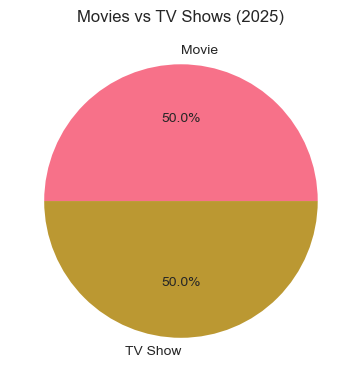

In [36]:
# Análisis de tipos de contenido
plt.figure(figsize=(15, 10))

# Movies vs TV Shows
plt.subplot(2, 3, 1)
type_counts = netflix_clean['type'].value_counts()
plt.pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%')
plt.title('Movies vs TV Shows (2025)')

Text(0.5, 0, 'Frecuencia')

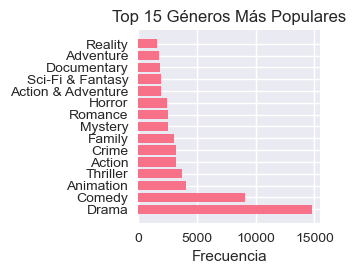

In [40]:
# Top 15 géneros
plt.subplot(2, 3, 2)
all_genres = []
for genres in netflix_clean['genres'].dropna():
    if genres != 'Unknown':
        all_genres.extend([g.strip() for g in str(genres).split(',')])
genre_counts = Counter(all_genres)
top_genres = dict(genre_counts.most_common(15))
plt.barh(list(top_genres.keys()), list(top_genres.values()))
plt.title('Top 15 Géneros Más Populares')
plt.xlabel('Frecuencia')


Text(0, 0.5, 'Frecuencia')

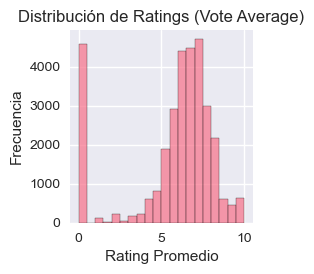

In [42]:
# Distribución de ratings promedio
plt.subplot(2, 3, 3)
plt.hist(netflix_clean['vote_average'].dropna(), bins=20, alpha=0.7, edgecolor='black')
plt.title('Distribución de Ratings (Vote Average)')
plt.xlabel('Rating Promedio')
plt.ylabel('Frecuencia')

Text(0.5, 0, 'Cantidad de Títulos')

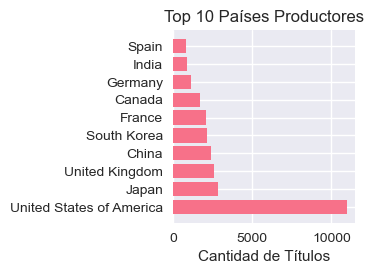

In [44]:
# Top 10 países
plt.subplot(2, 3, 4)
all_countries = []
for countries in netflix_clean['country'].dropna():
    if countries != 'Unknown':
        all_countries.extend([c.strip() for c in str(countries).split(',')])
country_counts = Counter(all_countries)
top_countries = dict(country_counts.most_common(10))
plt.barh(list(top_countries.keys()), list(top_countries.values()))
plt.title('Top 10 Países Productores')
plt.xlabel('Cantidad de Títulos')

Text(0.5, 1.0, 'Popularidad vs Rating')

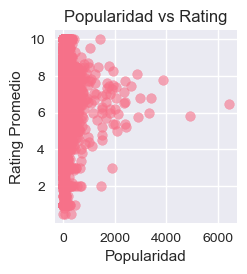

In [46]:
# Popularidad vs Rating
plt.subplot(2, 3, 5)
valid_data = netflix_clean[(netflix_clean['popularity'] > 0) & (netflix_clean['vote_average'] > 0)]
plt.scatter(valid_data['popularity'], valid_data['vote_average'], alpha=0.6)
plt.xlabel('Popularidad')
plt.ylabel('Rating Promedio')
plt.title('Popularidad vs Rating')


### Análisis de Top Contenido

In [52]:
# Top 10 películas/series mejor valoradas
print("TOP 10 CONTENIDO MEJOR VALORADO:")
print("="*50)
top_rated = netflix_clean[netflix_clean['vote_count'] >= 100].nlargest(10, 'vote_average')
for idx, row in top_rated.iterrows():
    print(f"{row['title']} ({row['type']}) - Rating: {row['vote_average']:.1f} - Votos: {row['vote_count']}")

# Top 10 contenido más popular
print("\n\nTOP 10 CONTENIDO MÁS POPULAR:")
print("="*50)
top_popular = netflix_clean.nlargest(10, 'popularity')
for idx, row in top_popular.iterrows():
    print(f"{row['title']} ({row['type']}) - Popularidad: {row['popularity']:.1f}")

TOP 10 CONTENIDO MEJOR VALORADO:
Nude (Movie) - Rating: 9.5 - Votos: 161
Succubus (Movie) - Rating: 9.5 - Votos: 157
Kill Shot (Movie) - Rating: 9.3 - Votos: 158
Break the Silence: The Movie (Movie) - Rating: 9.0 - Votos: 183
The Three Deaths of Marisela Escobedo (Movie) - Rating: 8.9 - Votos: 228
BTS: Permission to Dance on Stage - LA (Movie) - Rating: 8.9 - Votos: 157
The Good Bad Mother (TV Show) - Rating: 8.9 - Votos: 149
Adventure Time: Fionna & Cake (TV Show) - Rating: 8.9 - Votos: 208
The Boy's Word: Blood on the Asphalt (TV Show) - Rating: 8.9 - Votos: 182
Arcane (TV Show) - Rating: 8.8 - Votos: 4932


TOP 10 CONTENIDO MÁS POPULAR:
The Late Show with Stephen Colbert (TV Show) - Popularidad: 6421.9
The Tonight Show Starring Jimmy Fallon (TV Show) - Popularidad: 4925.3
The Gorge (Movie) - Popularidad: 3876.0
Good Mythical Morning (TV Show) - Popularidad: 3414.5
Flight Risk (Movie) - Popularidad: 3320.6
Chronicles of the Sun (TV Show) - Popularidad: 2987.5
Volta por Cima (TV Show)

### Sistema de Recomendaciones Básico (Solo Descripción)
Descripción: Sistema simple basado únicamente en las descripciones del contenido.

Creación de Matriz TF-IDF

In [57]:
# Preparar descripciones para TF-IDF
print("Creando sistema de recomendaciones básico...")

# Limpiar descripciones
netflix_clean['description_clean'] = netflix_clean['description'].fillna('').apply(clean_text_feature)

# Crear vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.8
)

# Crear matriz TF-IDF
tfidf_matrix = tfidf_vectorizer.fit_transform(netflix_clean['description_clean'])
print(f"Matriz TF-IDF creada: {tfidf_matrix.shape}")

# Calcular similitud coseno
cosine_sim_basic = linear_kernel(tfidf_matrix, tfidf_matrix)
print(f"Matriz de similitud básica: {cosine_sim_basic.shape}")

Creando sistema de recomendaciones básico...
Matriz TF-IDF creada: (32000, 5000)
Matriz de similitud básica: (32000, 32000)


 Función de Recomendaciones Básica

In [60]:
# Crear índices para búsqueda rápida
indices_basic = pd.Series(netflix_clean.index, index=netflix_clean['title']).drop_duplicates()

def get_basic_recommendations(title, num_recommendations=10):
    """
    Sistema básico de recomendaciones basado solo en descripciones
    """
    try:
        # Buscar índice del título
        idx = indices_basic[title]
        
        # Obtener puntuaciones de similitud
        sim_scores = list(enumerate(cosine_sim_basic[idx]))
        
        # Ordenar por similitud
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        
        # Obtener top recomendaciones (excluyendo el título original)
        sim_scores = sim_scores[1:num_recommendations+1]
        
        # Obtener índices
        movie_indices = [i[0] for i in sim_scores]
        
        # Devolver información completa
        recommendations = netflix_clean.iloc[movie_indices][
            ['title', 'type', 'genres', 'vote_average', 'popularity']
        ]
        
        return recommendations
        
    except KeyError:
        print(f"Título '{title}' no encontrado en el dataset")
        available_titles = netflix_clean['title'].str.contains(title, case=False, na=False)
        suggestions = netflix_clean[available_titles]['title'].head(5).tolist()
        if suggestions:
            print(f"Títulos similares encontrados: {suggestions}")
        return None

# Prueba del sistema básico
print("PRUEBA DEL SISTEMA BÁSICO:")
print("="*40)
test_title = netflix_clean['title'].iloc[0]
print(f"Recomendaciones para: '{test_title}'")
basic_recs = get_basic_recommendations(test_title, 5)
if basic_recs is not None:
    print(basic_recs[['title', 'type', 'vote_average']])

PRUEBA DEL SISTEMA BÁSICO:
Recomendaciones para: 'Shrek Forever After'
                                         title     type  vote_average
1316                    This Must Be the Place    Movie         7.000
4883   The Disappearance of Eleanor Rigby: Him    Movie         6.700
4661   The Disappearance of Eleanor Rigby: Her    Movie         6.700
30923                      A Love So Beautiful  TV Show         8.500
5789                       Sanjay's Super Team    Movie         6.422


#### Sistema de Recomendaciones Avanzado (Múltiples Características)
Descripción: Sistema mejorado que combina múltiples características del contenido.

Creación del "Soup" Mejorado

In [64]:
# Función para crear soup mejorado con todas las características
def create_enhanced_soup(row):
    """
    Crea una representación textual combinada de todas las características relevantes
    """
    # Características principales
    title = str(row.get('title', '')).lower().replace(' ', '')
    genres = str(row.get('clean_genres', ''))
    director = str(row.get('clean_director', ''))
    cast = str(row.get('clean_cast', ''))
    description = str(row.get('clean_description', ''))
    country = str(row.get('clean_country', ''))
    
    # Ponderación: géneros y director tienen más peso
    soup = (
        f"{title} " +
        f"{genres} {genres} " +  # Géneros con doble peso
        f"{director} {director} " +  # Director con doble peso
        f"{cast} " +
        f"{description} " +
        f"{country}"
    )
    
    return soup.strip()

# Crear soup para todo el dataset
print("Creando características combinadas mejoradas...")
netflix_clean['enhanced_soup'] = netflix_clean.apply(create_enhanced_soup, axis=1)

# Mostrar ejemplo de soup
print("Ejemplo de soup mejorado:")
print(f"Título: {netflix_clean.iloc[0]['title']}")
print(f"Soup: {netflix_clean.iloc[0]['enhanced_soup'][:200]}...")

Creando características combinadas mejoradas...
Ejemplo de soup mejorado:
Título: Shrek Forever After
Soup: shrekforeverafter comedy  adventure  fantasy  animation  family comedy  adventure  fantasy  animation  family mike mitchell mike mitchell mike myers  eddie murphy  cameron diaz  antonio banderas  walt...


Vectorización con CountVectorizer

In [67]:
# Crear vectorizador mejorado
count_vectorizer = CountVectorizer(
    max_features=8000,
    stop_words='english',
    ngram_range=(1, 3),
    min_df=1,
    max_df=0.9
)

# Crear matriz de características
print("Creando matriz de características mejorada...")
count_matrix = count_vectorizer.fit_transform(netflix_clean['enhanced_soup'])
print(f"Matriz de características: {count_matrix.shape}")

# Calcular similitud coseno mejorada
cosine_sim_enhanced = cosine_similarity(count_matrix, count_matrix)
print(f"Matriz de similitud mejorada: {cosine_sim_enhanced.shape}")

Creando matriz de características mejorada...
Matriz de características: (32000, 8000)
Matriz de similitud mejorada: (32000, 32000)


#### Sistema de Recomendaciones Mejorado con Análisis Paso a Paso

In [73]:
# Crear índices para el sistema mejorado
netflix_clean_reset = netflix_clean.reset_index(drop=True)
indices_enhanced = pd.Series(netflix_clean_reset.index, index=netflix_clean_reset['title']).drop_duplicates()

def normalize_title_search(title):
    """
    Normaliza título para búsqueda flexible
    """
    return title.lower().strip()

def find_similar_titles(search_title, dataset, max_suggestions=5):
    """
    Encuentra títulos similares si no se encuentra coincidencia exacta
    """
    normalized_search = normalize_title_search(search_title)
    
    # Buscar coincidencias parciales
    partial_matches = dataset[
        dataset['title'].str.lower().str.contains(normalized_search, na=False)
    ]['title'].head(max_suggestions).tolist()
    
    return partial_matches

def get_enhanced_recommendations_detailed(title, num_recommendations=10):
    """
    Sistema avanzado de recomendaciones con análisis detallado paso a paso
    """
    print(f"\n{'='*60}")
    print(f"SISTEMA AVANZADO DE RECOMENDACIONES")
    print(f"Búsqueda para: '{title}'")
    print(f"{'='*60}")
    
    # Paso 1: Búsqueda del título
    try:
        idx = indices_enhanced[title]
        print(f"✓ Título encontrado en índice: {idx}")
    except KeyError:
        print(f"✗ Título '{title}' no encontrado exactamente")
        suggestions = find_similar_titles(title, netflix_clean_reset)
        if suggestions:
            print(f"Títulos similares encontrados:")
            for i, suggestion in enumerate(suggestions, 1):
                print(f"  {i}. {suggestion}")
        return None
    
    # Paso 2: Obtener información del título original
    original_item = netflix_clean_reset.iloc[idx]
    print(f"\nINFORMACIÓN DEL TÍTULO ORIGINAL:")
    print(f"  Tipo: {original_item['type']}")
    print(f"  Géneros: {original_item['genres']}")
    print(f"  Director: {original_item['director']}")
    print(f"  Rating: {original_item['vote_average']:.1f}")
    print(f"  Popularidad: {original_item['popularity']:.1f}")
    
    # Paso 3: Calcular similitudes
    print(f"\nCALCULANDO SIMILITUDES...")
    sim_scores = list(enumerate(cosine_sim_enhanced[idx]))
    print(f"  Similitudes calculadas para {len(sim_scores)} títulos")
    
    # Paso 4: Ordenar y seleccionar mejores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    print(f"  Mejor similitud encontrada: {sim_scores[0][1]:.4f} (título original)")
    print(f"  Segunda mejor similitud: {sim_scores[1][1]:.4f}")
    
    # Obtener recomendaciones (excluyendo original)
    top_scores = sim_scores[1:num_recommendations+1]
    movie_indices = [i[0] for i in top_scores]
    
    # Paso 5: Generar recomendaciones detalladas
    print(f"\nTOP {num_recommendations} RECOMENDACIONES:")
    print(f"{'-'*60}")
    
    recommendations_detailed = []
    for i, (original_idx, similarity) in enumerate(top_scores, 1):
        rec_item = netflix_clean_reset.iloc[original_idx]
        
        rec_info = {
            'rank': i,
            'title': rec_item['title'],
            'type': rec_item['type'],
            'genres': rec_item['genres'],
            'director': rec_item['director'],
            'vote_average': rec_item['vote_average'],
            'popularity': rec_item['popularity'],
            'similarity_score': similarity
        }
        
        recommendations_detailed.append(rec_info)
        
        print(f"{i:2}. {rec_item['title']} ({rec_item['type']})")
        print(f"    Similitud: {similarity:.4f}")
        print(f"    Géneros: {rec_item['genres']}")
        print(f"    Rating: {rec_item['vote_average']:.1f} | Popularidad: {rec_item['popularity']:.1f}")
        print()
    
    return pd.DataFrame(recommendations_detailed)

# Función simplificada para uso rápido
def get_enhanced_recommendations(title, num_recommendations=10):
    """
    Versión simplificada del sistema avanzado
    """
    try:
        idx = indices_enhanced[title]
        sim_scores = list(enumerate(cosine_sim_enhanced[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:num_recommendations+1]
        movie_indices = [i[0] for i in sim_scores]
        
        return netflix_clean_reset.iloc[movie_indices][
            ['title', 'type', 'genres', 'vote_average', 'popularity']
        ]
    except KeyError:
        return find_similar_titles(title, netflix_clean_reset)

#### Pruebas del Sistema Completo
Descripción: Pruebas exhaustivas del sistema de recomendaciones con diferentes tipos de contenido.

In [76]:
# Prueba 1: Película popular
print("PRUEBA 1: PELÍCULA POPULAR")
if 'Inception' in netflix_clean_reset['title'].values:
    inception_recs = get_enhanced_recommendations_detailed('Inception', 5)
else:
    # Usar primera película disponible
    sample_movie = netflix_clean_reset[netflix_clean_reset['type'] == 'Movie']['title'].iloc[0]
    print(f"Usando película de muestra: {sample_movie}")
    movie_recs = get_enhanced_recommendations_detailed(sample_movie, 5)

PRUEBA 1: PELÍCULA POPULAR

SISTEMA AVANZADO DE RECOMENDACIONES
Búsqueda para: 'Inception'
✓ Título encontrado en índice: 1

INFORMACIÓN DEL TÍTULO ORIGINAL:
  Tipo: Movie
  Géneros: Action, Science Fiction, Adventure
  Director: Christopher Nolan
  Rating: 8.4
  Popularidad: 156.2

CALCULANDO SIMILITUDES...
  Similitudes calculadas para 32000 títulos
  Mejor similitud encontrada: 1.0000 (título original)
  Segunda mejor similitud: 0.6281

TOP 5 RECOMENDACIONES:
------------------------------------------------------------
 1. Apocalypse of Ice (Movie)
    Similitud: 0.6281
    Géneros: Science Fiction, Adventure, Action
    Rating: 3.8 | Popularidad: 6.5

 2. Moonfall (Movie)
    Similitud: 0.6233
    Géneros: Science Fiction, Adventure, Action
    Rating: 6.3 | Popularidad: 50.7

 3. Battle of the Damned (Movie)
    Similitud: 0.6232
    Géneros: Action, Science Fiction, Adventure
    Rating: 4.6 | Popularidad: 8.8

 4. Star Trek: Section 31 (Movie)
    Similitud: 0.6165
    Géneros: 

#### Análisis de Rendimiento del Sistema
Descripción: Evaluación del rendimiento y calidad de las recomendaciones.

In [79]:
# Función para analizar calidad de recomendaciones
def analyze_recommendation_quality(original_title, recommendations_df):
    """
    Analiza la calidad de las recomendaciones generadas
    """
    if recommendations_df is None or len(recommendations_df) == 0:
        return None
    
    # Obtener información del título original
    original_idx = indices_enhanced[original_title]
    original_item = netflix_clean_reset.iloc[original_idx]
    
    print(f"\nANÁLISIS DE CALIDAD DE RECOMENDACIONES")
    print(f"{'='*50}")
    print(f"Título original: {original_title}")
    print(f"Tipo original: {original_item['type']}")
    print(f"Géneros originales: {original_item['genres']}")
    
    # Análisis de coincidencias de tipo
    same_type = sum(1 for _, rec in recommendations_df.iterrows() if rec['type'] == original_item['type'])
    print(f"\nCoincidencias de tipo: {same_type}/{len(recommendations_df)} ({same_type/len(recommendations_df)*100:.1f}%)")
    
    # Análisis de géneros similares
    original_genres = set(str(original_item['genres']).lower().split(','))
    genre_overlaps = []
    
    for _, rec in recommendations_df.iterrows():
        rec_genres = set(str(rec['genres']).lower().split(','))
        overlap = len(original_genres.intersection(rec_genres))
        genre_overlaps.append(overlap)
    
    avg_genre_overlap = np.mean(genre_overlaps)
    print(f"Promedio de géneros coincidentes: {avg_genre_overlap:.1f}")
    
    # Análisis de ratings
    avg_rating = recommendations_df['vote_average'].mean()
    original_rating = original_item['vote_average']
    print(f"Rating promedio recomendaciones: {avg_rating:.1f}")
    print(f"Rating original: {original_rating:.1f}")
    
    # Análisis de similitud
    avg_similarity = recommendations_df['similarity_score'].mean()
    print(f"Similitud promedio: {avg_similarity:.4f}")
    
    return {
        'same_type_percentage': same_type/len(recommendations_df)*100,
        'avg_genre_overlap': avg_genre_overlap,
        'avg_rating': avg_rating,
        'avg_similarity': avg_similarity
    }

# Realizar análisis de calidad en las pruebas anteriores
if 'movie_recs' in locals() and movie_recs is not None:
    quality_analysis = analyze_recommendation_quality(sample_movie, movie_recs)

#### Función de Búsqueda Inteligente
Descripción: Sistema de búsqueda que maneja múltiples variaciones de títulos.

In [82]:
def intelligent_search_and_recommend(search_query, num_recommendations=5, show_process=True):
    """
    Sistema de búsqueda inteligente que maneja variaciones de títulos
    """
    if show_process:
        print(f"\n{'='*60}")
        print(f"BÚSQUEDA INTELIGENTE: '{search_query}'")
        print(f"{'='*60}")
    
    # Intentar búsqueda exacta
    if search_query in indices_enhanced:
        if show_process:
            print("✓ Coincidencia exacta encontrada")
        return get_enhanced_recommendations_detailed(search_query, num_recommendations)
    
    # Búsqueda flexible
    normalized_query = normalize_title_search(search_query)
    
    # Buscar coincidencias parciales
    partial_matches = netflix_clean_reset[
        netflix_clean_reset['title'].str.lower().str.contains(normalized_query, na=False, regex=False)
    ]
    
    if len(partial_matches) > 0:
        if show_process:
            print(f"✓ Encontradas {len(partial_matches)} coincidencias parciales:")
            for i, title in enumerate(partial_matches['title'].head(3), 1):
                print(f"  {i}. {title}")
        
        # Usar la primera coincidencia para recomendaciones
        best_match = partial_matches.iloc[0]['title']
        if show_process:
            print(f"\nUsando mejor coincidencia: '{best_match}'")
        
        return get_enhanced_recommendations_detailed(best_match, num_recommendations)
    
    else:
        if show_process:
            print("✗ No se encontraron coincidencias")
            print("Sugerencias:")
            print("  - Verifique la ortografía del título")
            print("  - Intente con palabras clave del título")
            print("  - Use términos en inglés si es una producción internacional")
        
        return None

# Ejemplos de búsqueda inteligente
test_searches = ["Shrek", "Inception", "Harry Potter", "Avengers"]

for search in test_searches:
    if any(netflix_clean_reset['title'].str.contains(search, case=False, na=False)):
        print(f"\n{'*'*40}")
        print(f"Probando búsqueda: '{search}'")
        result = intelligent_search_and_recommend(search, 3, show_process=False)
        if result is not None:
            print("✓ Recomendaciones generadas exitosamente")
        break


****************************************
Probando búsqueda: 'Shrek'

SISTEMA AVANZADO DE RECOMENDACIONES
Búsqueda para: 'Shrek Forever After'
✓ Título encontrado en índice: 0

INFORMACIÓN DEL TÍTULO ORIGINAL:
  Tipo: Movie
  Géneros: Comedy, Adventure, Fantasy, Animation, Family
  Director: Mike Mitchell
  Rating: 6.4
  Popularidad: 203.9

CALCULANDO SIMILITUDES...
  Similitudes calculadas para 32000 títulos
  Mejor similitud encontrada: 1.0000 (título original)
  Segunda mejor similitud: 0.6025

TOP 3 RECOMENDACIONES:
------------------------------------------------------------
 1. The Loud House Movie (Movie)
    Similitud: 0.6025
    Géneros: Animation, Family, Comedy, Adventure, Fantasy
    Rating: 7.3 | Popularidad: 18.3

 2. Marmaduke (Movie)
    Similitud: 0.4615
    Géneros: Animation, Family, Comedy, Adventure
    Rating: 5.0 | Popularidad: 14.8

 3. Donkey's Christmas Shrektacular (Movie)
    Similitud: 0.4519
    Géneros: Fantasy, Animation, Comedy, Family
    Rating: 5.9 |